In [1]:
!pip -q install geoopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 7.7 MB/s eta 0:00:00


In [9]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import geoopt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)


def lorenz_attractor(
    y0=(0.1, 0.0, 0.0), t1=50.0, dt=0.01, sigma=10.0, rho=28.0, beta=8 / 3
):
    y0 = torch.Tensor(y0)
    t = torch.arange(0, t1 + dt, dt)
    traj = torch.zeros((len(t), 3))
    traj[0] = y0

    def f(y):
        x, yv, z = y
        return torch.Tensor([sigma * (yv - x), x * (rho - z) - yv, x * yv - beta * z])

    for i in range(len(t) - 1):
        y = traj[i]
        k1 = f(y)
        k2 = f(y + 0.5 * dt * k1)
        k3 = f(y + 0.5 * dt * k2)
        k4 = f(y + dt * k3)
        traj[i + 1] = y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

    return traj


data = lorenz_attractor()
obs_dim = data.shape[1]

X1 = data[:, 0]
X2 = data[:, 1]


def demb(signal, m, tau):
    emb = torch.zeros(len(signal) - (m - 1) * tau, m)
    for i in range((m - 1) * tau, len(signal)):
        emb[i - (m - 1) * tau] = torch.tensor([signal[i - j * tau] for j in range(m)])

    return emb


X1_emb = demb(X1, m=9, tau=10)
X2_emb = demb(X2, m=9, tau=10)

T, num_chanels = X1_emb.shape
dt = 0.01
window_sec = 1
window_size = int(window_sec / dt)
num_windows = T // window_size

X1_trimmed = X1_emb[: num_windows * window_size]

X1_windows = (
    torch.tensor(
        X1_trimmed.reshape(num_windows, window_size, num_chanels), dtype=torch.float
    )
    .permute(0, 2, 1)
    .to(device)
)

X2_trimmed = X2_emb[: num_windows * window_size]

X2_windows = (
    torch.tensor(
        X2_trimmed.reshape(num_windows, window_size, num_chanels), dtype=torch.float
    )
    .permute(0, 2, 1)
    .to(device)
)

C1 = torch.zeros(len(X1_windows), 9, 9)
C2 = torch.zeros(len(X1_windows), 9, 9)

for i in range(len(X1_windows)):
    C1[i] = torch.cov(X1_windows[i]) + 1e-3 * torch.eye(X1_windows[i].shape[0]).to(
        device
    )
    C2[i] = torch.cov(X2_windows[i]) + 1e-3 * torch.eye(X1_windows[i].shape[0]).to(
        device
    )


class SPDPairDataset(Dataset):
    def __init__(self, Cs1, Cs2):
        self.Cs1 = Cs1
        self.Cs2 = Cs2

    def __len__(self):
        return self.Cs1.shape[0]

    def __getitem__(self, idx):
        return self.Cs1[idx], self.Cs2[idx]


dataset = SPDPairDataset(C1, C2)
loader = DataLoader(dataset, batch_size=3, shuffle=True, drop_last=True)


class BiMap(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        W = torch.qr(torch.randn(in_dim, out_dim))[0]
        self.W = geoopt.ManifoldParameter(W, manifold=geoopt.Stiefel())

    def forward(self, X):
        return self.W.T @ X @ self.W


class ReBiMap(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        W = torch.qr(torch.randn(out_dim, in_dim))[0]
        self.W = geoopt.ManifoldParameter(W, manifold=geoopt.Stiefel())

    def forward(self, X):
        return self.W @ X @ self.W.T


class ReEig(nn.Module):
    def __init__(self, eps=1e-4):
        super().__init__()
        self.eps = eps

    def forward(self, X):
        eigvals, eigvecs = torch.linalg.eigh(X)
        eigvals = torch.clamp(eigvals, min=self.eps)
        return eigvecs @ torch.diag_embed(eigvals) @ eigvecs.transpose(-2, -1)


class LogEig(nn.Module):
    def forward(self, X):
        eigvals, eigvecs = torch.linalg.eigh(X)
        log_eigvals = torch.log(eigvals)
        return eigvecs @ torch.diag_embed(log_eigvals) @ eigvecs.transpose(-2, -1)


class ExpEig(nn.Module):
    def forward(self, X):
        eigvals, eigvecs = torch.linalg.eigh(X)
        exp_eigvals = torch.exp(eigvals)
        return eigvecs @ torch.diag_embed(exp_eigvals) @ eigvecs.transpose(-2, -1)


class SPDEncoder(nn.Module):
    def __init__(self, input_dim, k=3):
        super().__init__()
        self.SPDNet = nn.Sequential(
            BiMap(9, 7), ReEig(), BiMap(7, 5), ReEig(), BiMap(5, 3), ReEig(), LogEig()
        )
        self.k = k
        self.vech_dim = k * (k + 1) // 2

    def forward(self, X):
        C = self.SPDNet(X)
        idx = torch.triu_indices(self.k, self.k)
        vech = C[:, idx[0], idx[1]]
        return vech


class SPDDecoder(nn.Module):
    def __init__(self, k=3, output_dim=9):
        super().__init__()
        self.SPDNet = nn.Sequential(
            ExpEig(),
            ReBiMap(3, 5),
            ReEig(),
            ReBiMap(5, 7),
            ReEig(),
            ReBiMap(7, 9),
            ReEig(),
        )
        self.k = k

    def forward(self, vech):
        batch_size = vech.shape[0]
        X = torch.zeros((batch_size, self.k, self.k), device=vech.device)
        idx = torch.triu_indices(self.k, self.k)
        X[:, idx[0], idx[1]] = vech
        X = (
            X
            + X.transpose(-2, -1)
            - torch.diag_embed(torch.diagonal(X, dim1=-2, dim2=-1))
        )

        return self.SPDNet(X)


mlp_link = nn.Sequential(nn.Linear(6, 6), nn.ReLU(), nn.Linear(6, 6)).to(device)

encoder1 = SPDEncoder(C1.shape[1]).to(device)
encoder2 = SPDEncoder(C2.shape[1]).to(device)
decoder1 = SPDDecoder(output_dim=C1.shape[1]).to(device)
decoder2 = SPDDecoder(output_dim=C2.shape[1]).to(device)

optimizer = geoopt.optim.RiemannianAdam(
    list(encoder1.parameters())
    + list(encoder2.parameters())
    + list(decoder1.parameters())
    + list(decoder2.parameters())
    + list(mlp_link.parameters()),
    lr=1e-3,
)

epochs = 400
mse_loss = nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0
    for C1_batch, C2_batch in loader:
        C1_batch = C1_batch.to(device)
        C2_batch = C2_batch.to(device)
        optimizer.zero_grad()

        z1 = encoder1(C1_batch)
        z2 = encoder2(C2_batch)

        z1_to_z2 = mlp_link(z1)

        X1_recon = decoder1(z1)
        X2_recon = decoder2(z2)

        loss_recon = mse_loss(X1_recon, C1_batch) + mse_loss(X2_recon, C2_batch)
        loss_latent = mse_loss(z1_to_z2, z2)
        loss = loss_recon + loss_latent

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * C1_batch.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss={avg_loss:.6e}")

/tmp/ipython-input-9626613.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X1_windows = torch.tensor(
/tmp/ipython-input-9626613.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X2_windows = torch.tensor(


Epoch 1/400, Loss=1.147860e+03
Epoch 2/400, Loss=1.070223e+03
Epoch 3/400, Loss=1.086662e+03
Epoch 4/400, Loss=1.056039e+03
Epoch 5/400, Loss=1.042481e+03
Epoch 6/400, Loss=9.725586e+02
Epoch 7/400, Loss=1.004627e+03
Epoch 8/400, Loss=9.445118e+02
Epoch 9/400, Loss=9.678473e+02
Epoch 10/400, Loss=9.077842e+02
Epoch 11/400, Loss=9.357752e+02
Epoch 12/400, Loss=9.280706e+02
Epoch 13/400, Loss=9.155199e+02
Epoch 14/400, Loss=8.695422e+02
Epoch 15/400, Loss=8.954788e+02
Epoch 16/400, Loss=8.515382e+02
Epoch 17/400, Loss=8.408129e+02
Epoch 18/400, Loss=8.144774e+02
Epoch 19/400, Loss=8.617325e+02
Epoch 20/400, Loss=8.531608e+02
Epoch 21/400, Loss=8.447306e+02
Epoch 22/400, Loss=8.399729e+02
Epoch 23/400, Loss=7.791934e+02
Epoch 24/400, Loss=7.907761e+02
Epoch 25/400, Loss=8.105417e+02
Epoch 26/400, Loss=7.718364e+02
Epoch 27/400, Loss=7.966650e+02
Epoch 28/400, Loss=7.770657e+02
Epoch 29/400, Loss=7.949800e+02
Epoch 30/400, Loss=7.608825e+02
Epoch 31/400, Loss=7.845958e+02
Epoch 32/400, Los

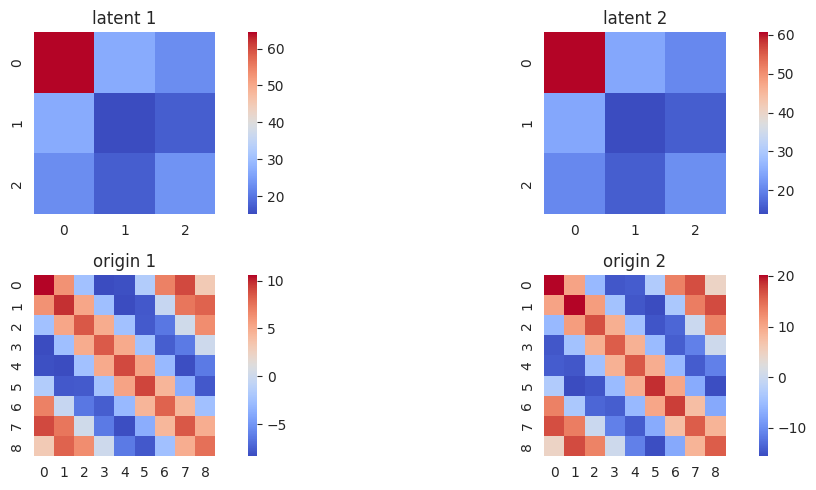

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

z1 = mlp_link(encoder1(C1[20].unsqueeze(0).to(device))).squeeze(0)
z2 = encoder2(C2[20].unsqueeze(0).to(device)).squeeze(0)

idx = torch.triu_indices(3, 3)
X = torch.zeros((3, 3), device=z1.device)

X[idx[0], idx[1]] = z1
X1 = X + X.transpose(-2, -1) - torch.diag_embed(torch.diagonal(X, dim1=-2, dim2=-1))

idx = torch.triu_indices(3, 3)
X = torch.zeros((3, 3), device=z1.device)

X[idx[0], idx[1]] = z2
X2 = X + X.transpose(-2, -1) - torch.diag_embed(torch.diagonal(X, dim1=-2, dim2=-1))

X1 = ExpEig()(X1).detach().cpu().numpy()
X2 = ExpEig()(X2).detach().cpu().numpy()

plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
sns.heatmap(X1, annot=False, fmt=".2f", cmap="coolwarm", square=True)
plt.title("latent 1")

plt.subplot(2, 2, 2)
sns.heatmap(X2, annot=False, fmt=".2f", cmap="coolwarm", square=True)
plt.title("latent 2")

plt.subplot(2, 2, 3)
sns.heatmap(C1[20], annot=False, fmt=".2f", cmap="coolwarm", square=True)
plt.title("origin 1")

plt.subplot(2, 2, 4)
sns.heatmap(C2[20], annot=False, fmt=".2f", cmap="coolwarm", square=True)
plt.title("origin 2")

plt.tight_layout()

plt.savefig("covariance_heatmaps.png", dpi=300)
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 001  train_loss 144.872329  val_loss 143.280960
Epoch 002  train_loss 139.941423  val_loss 141.357651
Epoch 003  train_loss 135.935918  val_loss 138.949615
Epoch 004  train_loss 132.302385  val_loss 136.036163
Epoch 005  train_loss 128.710555  val_loss 133.018463
Epoch 006  train_loss 125.348025  val_loss 130.261566
Epoch 007  train_loss 122.413341  val_loss 127.834450
Epoch 008  train_loss 119.844906  val_loss 125.693970
Epoch 009  train_loss 117.456027  val_loss 123.732216
Epoch 010  train_loss 115.167351  val_loss 121.895378
Epoch 011  train_loss 112.952167  val_loss 120.247528
Epoch 012  train_loss 110.813247  val_loss 118.785439
Epoch 013  train_loss 108.849905  val_loss 117.464256
Epoch 014  train_loss 106.948178  val_loss 116.201729
Epoch 015  train_loss 105.116732  val_loss 115.014175
Epoch 016  train_loss 103.322773  val_loss 113.880836
Epoch 017  train_loss 101.590801  val_loss 112.766350
Epoch 018  train_loss 99.930112  val_loss 111.705162
Epoch 019  train_loss 98.2903

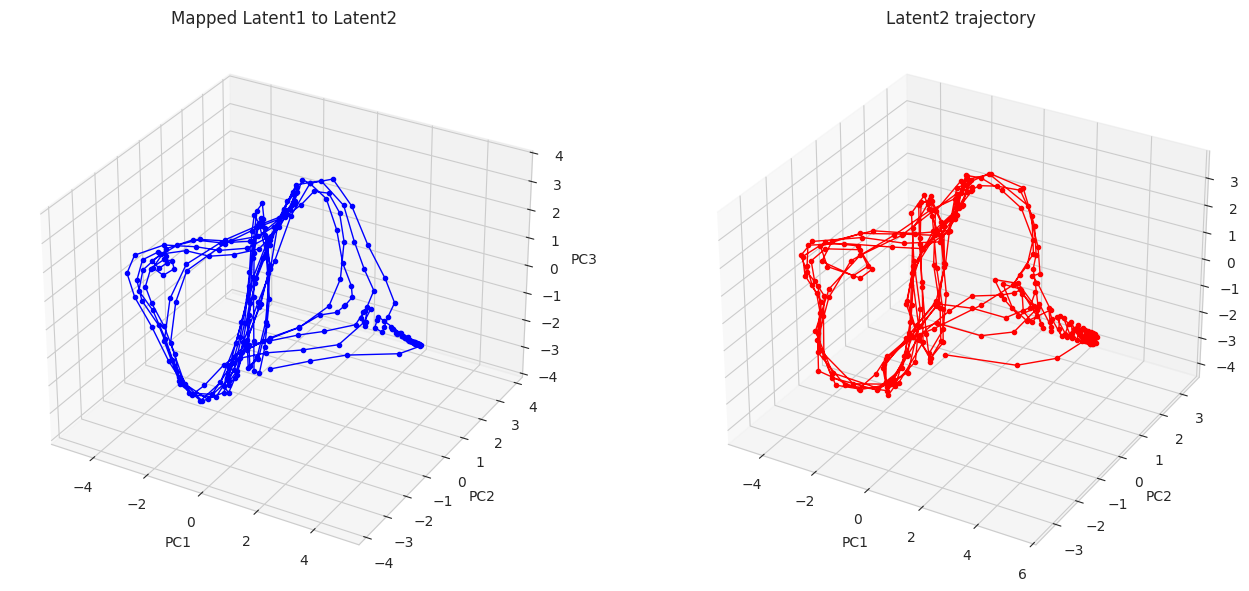

In [36]:
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


def gen_lorenz(N=2000, dt=0.01, x0=(1.0, 1.0, 1.0), sigma=10.0, rho=28.0, beta=8 / 3):
    xs = np.zeros((N, 3), dtype=np.float32)
    x = np.array(x0, dtype=np.float32)
    for i in range(N):
        xs[i] = x

        def f(v):
            return np.array(
                [
                    sigma * (v[1] - v[0]),
                    v[0] * (rho - v[2]) - v[1],
                    v[0] * v[1] - beta * v[2],
                ],
                dtype=np.float32,
            )

        k1 = f(x)
        k2 = f(x + 0.5 * dt * k1)
        k3 = f(x + 0.5 * dt * k2)
        k4 = f(x + dt * k3)
        x = x + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
    return xs


def delay_embed(signal, emb_dim=8, tau=1):
    N = len(signal)
    M = N - (emb_dim - 1) * tau
    if M <= 0:
        raise ValueError("Signal too short for embedding with chosen emb_dim/tau")
    X = np.zeros((M, emb_dim), dtype=np.float32)
    for i in range(M):
        X[i] = signal[i : i + emb_dim * tau : tau]
    return X


def make_windows(embeddings, seq_len=16, stride=2):
    n = embeddings.shape[0]
    windows = []
    starts = []
    for i in range(0, n - seq_len + 1, stride):
        windows.append(embeddings[i : i + seq_len])
        starts.append(i)
    return np.stack(windows), np.array(starts)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        L = x.size(1)
        return x + self.pe[:, :L].to(x.device)


class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=4, num_layers=1, latent_dim=8):
        super().__init__()
        self.enc_in = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=64
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pos = PositionalEncoding(d_model, max_len=1000)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.to_latent = nn.Linear(d_model, latent_dim)

        self.from_latent = nn.Linear(latent_dim, d_model)
        decoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=64
        )
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=num_layers)
        self.dec_out = nn.Linear(d_model, input_dim)

    def encode(self, x):
        x = self.enc_in(x) * math.sqrt(self.enc_in.out_features)
        x = self.pos(x)
        x = x.permute(1, 0, 2)
        h = self.encoder(x)
        h = h.permute(1, 2, 0)
        pooled = self.pool(h).squeeze(-1)
        z = self.to_latent(pooled)
        return z

    def decode(self, z, seq_len):
        h = self.from_latent(z)
        h_seq = h.unsqueeze(1).repeat(1, seq_len, 1)
        h_seq = self.pos(h_seq)
        h_seq = h_seq.permute(1, 0, 2)
        out = self.decoder(h_seq)
        out = out.permute(1, 0, 2)
        x_rec = self.dec_out(out)
        return x_rec

    def forward(self, x):
        z = self.encode(x)
        rec = self.decode(z, x.size(1))
        return rec, z


def run_pipeline(
    N=5000,
    emb_dim=10,
    tau=25,
    seq_len=50,
    stride=15,
    d_model=32,
    latent_dim=10,
    n_epochs=200,
    batch_size=128,
    lr=2e-3,
    device=None,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data = gen_lorenz(N=N)
    comp1 = data[:, 0].copy()
    comp2 = data[:, 1].copy()

    X1 = delay_embed(comp1, emb_dim=emb_dim, tau=tau)
    X2 = delay_embed(comp2, emb_dim=emb_dim, tau=tau)

    W1, s1 = make_windows(X1, seq_len=seq_len, stride=stride)
    W2, s2 = make_windows(X2, seq_len=seq_len, stride=stride)

    min_w = min(len(W1), len(W2))
    W1 = W1[:min_w]
    W2 = W2[:min_w]
    starts = s1[:min_w]

    train_frac = 0.8
    n_train = int(min_w * train_frac)
    train_W1 = torch.tensor(W1[:n_train], dtype=torch.float32)
    train_W2 = torch.tensor(W2[:n_train], dtype=torch.float32)
    test_W1 = torch.tensor(W1[n_train:], dtype=torch.float32)
    test_W2 = torch.tensor(W2[n_train:], dtype=torch.float32)

    train_loader = DataLoader(
        TensorDataset(train_W1, train_W2), batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        TensorDataset(test_W1, test_W2), batch_size=batch_size, shuffle=False
    )

    model1 = TransformerAutoencoder(
        input_dim=emb_dim, d_model=d_model, num_layers=1, latent_dim=latent_dim
    ).to(device)
    model2 = TransformerAutoencoder(
        input_dim=emb_dim, d_model=d_model, num_layers=1, latent_dim=latent_dim
    ).to(device)
    Lmap = nn.Linear(latent_dim, latent_dim).to(device)

    opt = torch.optim.Adam(
        list(model1.parameters()) + list(model2.parameters()) + list(Lmap.parameters()),
        lr=lr,
    )
    mse = nn.MSELoss()

    for epoch in range(1, n_epochs + 1):
        model1.train()
        model2.train()
        Lmap.train()
        running_loss = 0.0
        for b1, b2 in train_loader:
            b1 = b1.to(device)
            b2 = b2.to(device)
            opt.zero_grad()
            rec1, z1 = model1(b1)
            rec2, z2 = model2(b2)
            loss_rec = mse(rec1, b1) + mse(rec2, b2)
            loss_align = mse(Lmap(z1), z2)
            loss = loss_rec + 0.2 * loss_align
            loss.backward()
            opt.step()
            running_loss += loss.item() * b1.size(0)
        running_loss /= len(train_loader.dataset)

        model1.eval()
        model2.eval()
        Lmap.eval()
        val_loss = 0.0
        with torch.no_grad():
            for tb1, tb2 in test_loader:
                tb1 = tb1.to(device)
                tb2 = tb2.to(device)
                r1, z1t = model1(tb1)
                r2, z2t = model2(tb2)
                loss_rec = mse(r1, tb1) + mse(r2, tb2)
                loss_align = mse(Lmap(z1t), z2t)
                val_loss += (loss_rec + 0.2 * loss_align).item() * tb1.size(0)
            val_loss /= len(test_loader.dataset)
        print(
            f"Epoch {epoch:03d}  train_loss {running_loss:.6f}  val_loss {val_loss:.6f}"
        )

    model1.eval()
    model2.eval()
    Lmap.eval()
    with torch.no_grad():
        allW1 = torch.tensor(W1, dtype=torch.float32).to(device)
        allW2 = torch.tensor(W2, dtype=torch.float32).to(device)
        _, Z1 = model1(allW1)
        _, Z2 = model2(allW2)
        Z1_np = Z1.cpu().numpy()
        Z2_np = Z2.cpu().numpy()
        Z1_mapped = Lmap(Z1).cpu().numpy()

    pca2 = PCA(n_components=3)
    Z2_3d = pca2.fit_transform(Z2_np)
    Z1m_3d = pca2.transform(Z1_mapped)
    pca1 = PCA(n_components=3)
    Z1_3d = pca1.fit_transform(Z1_np)

    seg_len = min(300, len(Z1m_3d))
    ix = np.arange(seg_len)

    fig = plt.figure(figsize=(14, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot(
        Z1m_3d[ix, 0],
        Z1m_3d[ix, 1],
        Z1m_3d[ix, 2],
        marker=".",
        linewidth=1,
        color="blue",
    )
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_zlabel("PC3")
    ax1.set_title("Mapped Latent1 to Latent2")

    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    ax2.plot(
        Z2_3d[ix, 0], Z2_3d[ix, 1], Z2_3d[ix, 2], marker=".", linewidth=1, color="red"
    )
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.set_zlabel("PC3")
    ax2.set_title("Latent2 trajectory")

    plt.tight_layout()

    plt.savefig("latent_trajectories_side_by_side.png", dpi=300)
    plt.show()

    return {
        "Z1": Z1_np,
        "Z2": Z2_np,
        "Z1_mapped": Z1_mapped,
        "Z1_3d": Z1_3d,
        "Z2_3d": Z2_3d,
        "Z1m_3d": Z1m_3d,
        "starts": starts,
    }


info = run_pipeline()

/usr/local/lib/python3.12/dist-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Canonical correlations: [1. 1. 1.]
Epoch 0: loss = 0.240701
Epoch 400: loss = 0.182195
Epoch 800: loss = 0.135299
Epoch 1200: loss = 0.097840
Epoch 1600: loss = 0.068456


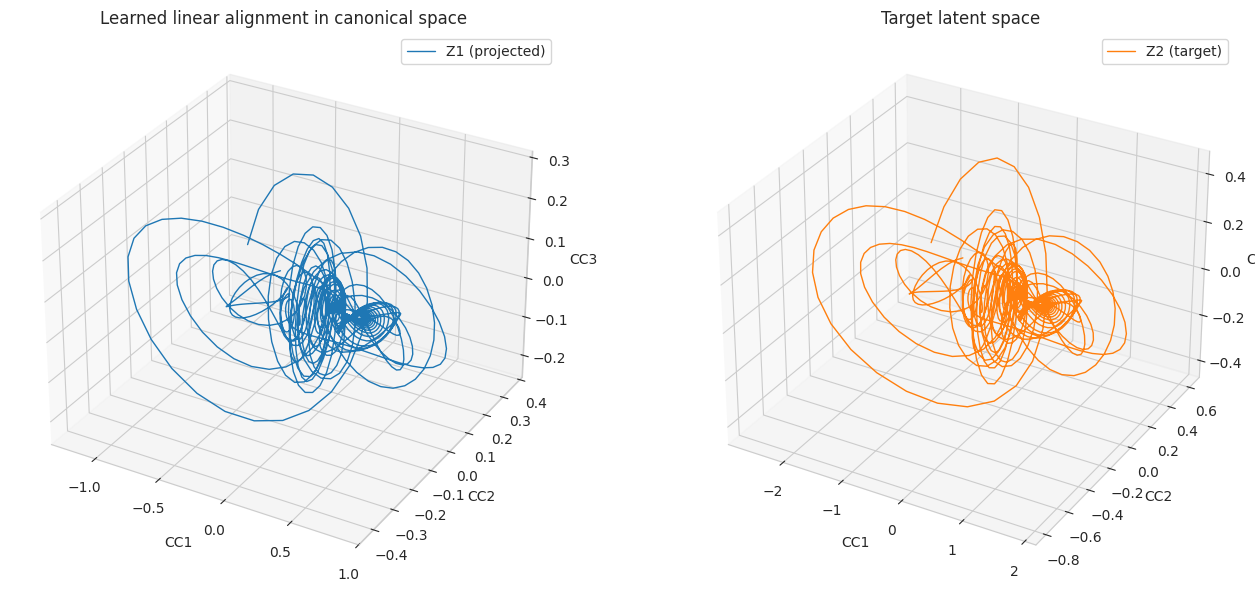

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
import torch
from torch import nn
from mpl_toolkits.mplot3d import Axes3D


def gen_lorenz(N=5000, dt=0.01, x0=(1.0, 1.0, 1.0), sigma=10.0, rho=28.0, beta=8 / 3):
    xs = np.zeros((N, 3), dtype=np.float32)
    x = np.array(x0, dtype=np.float32)
    for i in range(N):
        xs[i] = x

        def f(v):
            return np.array(
                [
                    sigma * (v[1] - v[0]),
                    v[0] * (rho - v[2]) - v[1],
                    v[0] * v[1] - beta * v[2],
                ],
                dtype=np.float32,
            )

        k1 = f(x)
        k2 = f(x + 0.5 * dt * k1)
        k3 = f(x + 0.5 * dt * k2)
        k4 = f(x + dt * k3)
        x = x + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
    return xs


data = gen_lorenz(N=5000)
x1 = data[:, 0]
x2 = data[:, 1]


def delay_embed(signal, m=8, tau=1):
    N = len(signal)
    M = N - (m - 1) * tau
    if M <= 0:
        raise ValueError("Signal too short for embedding with chosen emb_dim/tau")
    X = np.zeros((M, m), dtype=np.float32)
    for i in range(M):
        X[i] = signal[i : i + m * tau : tau]
    return X


m, tau = 15, 7
X1 = delay_embed(x1, m=m, tau=tau)
X2 = delay_embed(x2, m=m, tau=tau)
min_len = min(X1.shape[0], X2.shape[0])
X1, X2 = X1[:min_len], X2[:min_len]

cca = CCA(n_components=3)
Z1, Z2 = cca.fit_transform(X1, X2)

print("Canonical correlations:", np.corrcoef(Z1.T, Z2.T).diagonal()[:3])

Z1_t = torch.tensor(Z1, dtype=torch.float32)
Z2_t = torch.tensor(Z2, dtype=torch.float32)

linear = nn.Linear(3, 3, bias=False)
opt = torch.optim.Adam(linear.parameters(), lr=1e-3)

for epoch in range(2000):
    opt.zero_grad()
    Z1_proj = linear(Z1_t)
    loss = ((Z1_proj - Z2_t) ** 2).mean()
    loss.backward()
    opt.step()
    if epoch % 400 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.6f}")

Z1_aligned = linear(Z1_t).detach().numpy()

seg_len = min(2000, len(Z1))
ix = np.arange(seg_len)

fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.plot(
    Z1_aligned[ix, 0],
    Z1_aligned[ix, 1],
    Z1_aligned[ix, 2],
    linewidth=1,
    color="tab:blue",
    label="Z1 (projected)",
)
ax.set_title("Learned linear alignment in canonical space")
ax.set_xlabel("CC1")
ax.set_ylabel("CC2")
ax.set_zlabel("CC3")
ax.legend()

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot(
    Z2[ix, 0],
    Z2[ix, 1],
    Z2[ix, 2],
    linewidth=1,
    color="tab:orange",
    label="Z2 (target)",
)
ax2.set_title("Target latent space")
ax2.set_xlabel("CC1")
ax2.set_ylabel("CC2")
ax2.set_zlabel("CC3")
ax2.legend()

plt.tight_layout()

plt.savefig("latent_alignment_3d.png", dpi=300)

plt.show()

In [39]:
!pip -q install torchdiffeq

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/100] | Loss: 14.183976
Epoch [20/100] | Loss: 8.633930
Epoch [30/100] | Loss: 6.188432
Epoch [40/100] | Loss: 4.735234
Epoch [50/100] | Loss: 3.645278
Epoch [60/100] | Loss: 2.765545
Epoch [70/100] | Loss: 2.057208
Epoch [80/100] | Loss: 1.507901
Epoch [90/100] | Loss: 1.101932
Epoch [100/100] | Loss: 0.813141


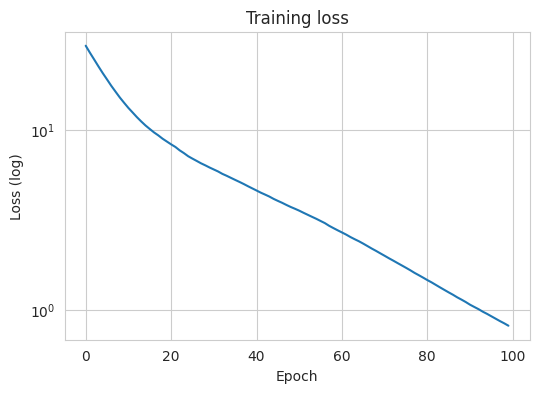

In [49]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from torchdiffeq import odeint

from tqdm.auto import tqdm

from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"


class GRANDBlock(nn.Module):
    def __init__(self, num_heads, num_chanels, featurs_dim, out_dim, rho=0.7):
        super().__init__()

        self.num_heads = num_heads
        self.num_chanels = num_chanels
        self.featurs_dim = featurs_dim
        self.out_dim = out_dim
        self.rho = rho

        self.register_buffer("eye", torch.eye(self.num_chanels))

        self.k = nn.Linear(self.featurs_dim, self.out_dim * self.num_heads)
        self.q = nn.Linear(self.featurs_dim, self.out_dim * self.num_heads)
        self.v = nn.Linear(self.featurs_dim, self.out_dim)

    def forward(
        self,
        x,
    ):

        k = self.k(x).reshape(-1, self.num_heads, self.num_chanels, self.out_dim)
        q = self.q(x).reshape(-1, self.num_heads, self.num_chanels, self.out_dim)
        v = self.v(x)

        att_scores = torch.einsum("bhcf,bhdf->bhcd", q, k) / (self.out_dim**0.5)

        att_map = torch.softmax(
            (torch.softmax(att_scores, dim=-1) > self.rho).long() * att_scores, dim=-1
        ).mean(dim=1)

        out = torch.einsum(
            "bcd,bdf->bcf",
            att_map - self.eye,
            v,
        )

        return out


class ODEFunc(nn.Module):
    def __init__(self, func, **kwargs):
        super().__init__()

        self.func = func
        self.kwargs = kwargs

    def forward(self, t, x):
        return self.func(x)


class GRAND(nn.Module):
    def __init__(self, num_heads, num_chanels, featurs_dim, out_dim):
        super().__init__()

        self.grand_encoder = ODEFunc(
            GRANDBlock(num_heads, num_chanels, featurs_dim, out_dim)
        )

    def forward(self, x, t):
        z = odeint(self.grand_encoder, x, t, method="rk4")[-1]

        return z


class GRANDAutoencoder(nn.Module):
    def __init__(self, num_heads, num_chanels, featurs_dim, latent_dim):
        super().__init__()

        self.encoder = ODEFunc(
            GRANDBlock(num_heads, num_chanels, featurs_dim, latent_dim)
        )
        self.decoder = ODEFunc(
            GRANDBlock(num_heads, num_chanels, latent_dim, featurs_dim)
        )

        self.enc_linear = nn.Linear(num_chanels, 3)

    def forward(self, x, t):
        z = odeint(self.encoder, x, t, method="rk4")[-1]
        z_lin = self.enc_linear(z.permute(0, 2, 1)).permute(0, 2, 1)

        x_hat = odeint(self.decoder, z, t, method="rk4")[-1]

        return z_lin, x_hat


def lorenz_attractor(
    y0=(0.1, 0.0, 0.0), t1=50.0, dt=0.01, sigma=10.0, rho=28.0, beta=8 / 3
):
    y0 = torch.Tensor(y0)
    t = torch.arange(0, t1 + dt, dt)
    traj = torch.zeros((len(t), 3))
    traj[0] = y0

    def f(y):
        x, yv, z = y
        return torch.Tensor([sigma * (yv - x), x * (rho - z) - yv, x * yv - beta * z])

    for i in range(len(t) - 1):
        y = traj[i]
        k1 = f(y)
        k2 = f(y + 0.5 * dt * k1)
        k3 = f(y + 0.5 * dt * k2)
        k4 = f(y + dt * k3)
        traj[i + 1] = y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

    return traj


X = lorenz_attractor()


def demb(signal, m, tau):
    emb = torch.zeros(len(signal) - (m - 1) * tau, m)
    for i in range((m - 1) * tau, len(signal)):
        emb[i - (m - 1) * tau] = torch.tensor([signal[i - j * tau] for j in range(m)])

    return emb


X1 = X[:, 0]
X2 = X[:, 1]
X1 = demb(X1, m=10, tau=25)
X2 = demb(X2, m=10, tau=25)

T, num_chanels = X1.shape
dt = 0.01
window_sec = 1
window_size = int(window_sec / dt)
num_windows = T // window_size


def create_windows_with_overlap(X, window_size, overlap, num_channels, device):
    X = np.array(X)
    stride = window_size - overlap
    num_windows = (len(X) - overlap) // stride

    X_trimmed = X[: num_windows * stride + overlap]

    X_windows = np.zeros((num_windows, window_size, num_channels), dtype=np.float32)
    for i in range(num_windows):
        start = i * stride
        end = start + window_size
        X_windows[i] = X_trimmed[start:end]

    X_windows = torch.tensor(X_windows, dtype=torch.float).permute(0, 2, 1).to(device)
    return X_windows, num_windows


overlap = window_size // 4
X1_windows, num_windows1 = create_windows_with_overlap(
    X1, window_size, overlap, num_chanels, device
)
X2_windows, num_windows2 = create_windows_with_overlap(
    X2, window_size, overlap, num_chanels, device
)


num_heads = 4
num_chanels = 10
feat_dim = window_size
latent_dim = window_size
small_latent_dim = 3
batch_size = 16
epochs = 100
lr = 1e-3

model1 = GRANDAutoencoder(num_heads, num_chanels, feat_dim, latent_dim).to(device)
model2 = GRANDAutoencoder(num_heads, num_chanels, feat_dim, latent_dim).to(device)
Lmap = nn.Linear(small_latent_dim, small_latent_dim).to(device)

opt = torch.optim.Adam(
    list(model1.parameters()) + list(model2.parameters()) + list(Lmap.parameters()),
    lr=lr,
)
mse = nn.MSELoss()

t_span = torch.linspace(0, 0.1, 15).to(device)

sns.set_style("whitegrid")

dataset = TensorDataset(X1_windows, X2_windows)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_history = []
for epoch in tqdm(range(epochs)):
    model1.train()
    model2.train()
    total_loss = 0.0

    for xb1, xb2 in dataloader:
        opt.zero_grad()

        z1_lin, x1_hat = model1(xb1, t_span)
        z2_lin, x2_hat = model2(xb2, t_span)

        rec_loss = mse(x1_hat.permute(0, 2, 1), xb1.permute(0, 2, 1)) + mse(
            x2_hat.permute(0, 2, 1), xb2.permute(0, 2, 1)
        )

        align_loss = mse(z1_lin.permute(0, 2, 1), z2_lin.permute(0, 2, 1))

        loss = rec_loss + 0.5 * align_loss

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(
        #     list(model1.parameters())
        #     + list(model2.parameters())
        #     + list(Lmap.parameters()),
        #     1.0,
        # )
        opt.step()

        total_loss += loss.item() * xb1.size(0)

    total_loss /= len(dataloader.dataset)
    loss_history.append(total_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss:.6f}")


plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss (log)")
plt.title("Training loss")
plt.show()

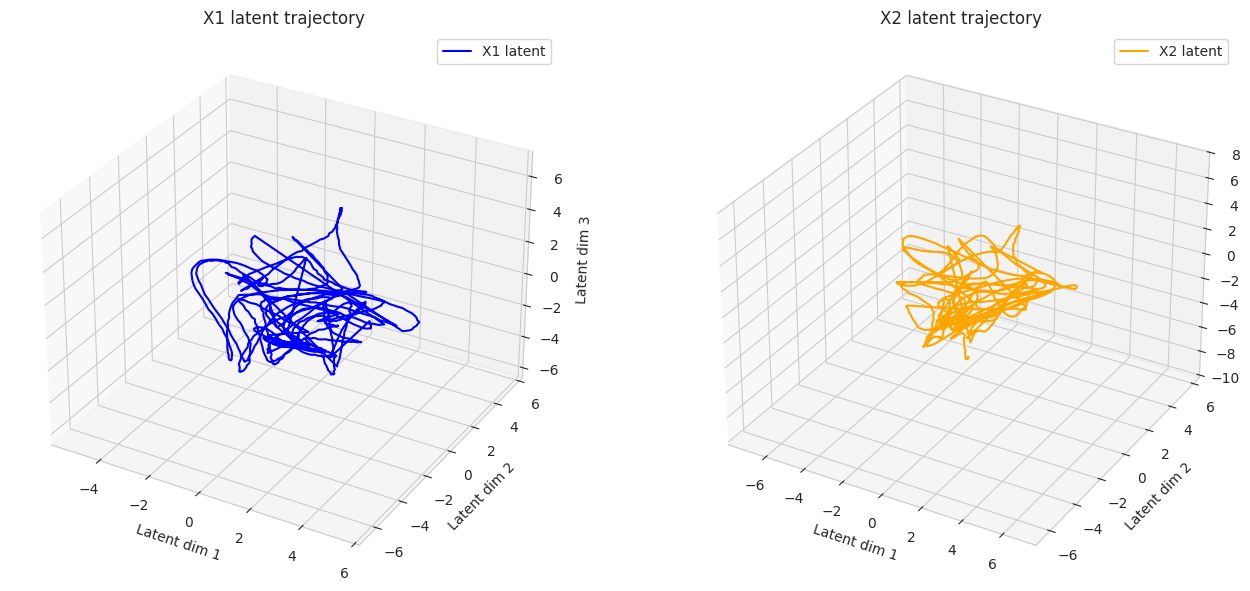

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

w1s = []
w2s = []

for wb in range(0, len(X1_windows), 4):
    z, _ = model1(X1_windows[wb].unsqueeze(0), t_span)
    w1s.append(z.permute(0, 2, 1).squeeze(0))

for wb in range(0, len(X2_windows), 4):
    z, _ = model2(X2_windows[wb].unsqueeze(0), t_span)
    w2s.append(z.permute(0, 2, 1).squeeze(0))

W1_cat = torch.cat(w1s, dim=0).detach().cpu().numpy()
W2_cat = torch.cat(w2s, dim=0).detach().cpu().numpy()

fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.plot(
    W1_cat[:, 0], W1_cat[:, 1], W1_cat[:, 2], color="blue", lw=1.5, label="X1 latent"
)
ax.set_xlabel("Latent dim 1")
ax.set_ylabel("Latent dim 2")
ax.set_zlabel("Latent dim 3")
ax.set_title("X1 latent trajectory")
ax.legend()

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot(
    W2_cat[:, 0], W2_cat[:, 1], W2_cat[:, 2], color="orange", lw=1.5, label="X2 latent"
)
ax2.set_xlabel("Latent dim 1")
ax2.set_ylabel("Latent dim 2")
ax2.set_zlabel("Latent dim 3")
ax2.set_title("X2 latent trajectory")
ax2.legend()

plt.tight_layout()

plt.savefig("latent_trajectories_all_windows.png", dpi=300)

plt.show()